#libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim


In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#part 1: prepare the data we will work on

In [3]:
cleaned_data=pd.read_csv('data.csv')

In [4]:
df = cleaned_data[:100]

In [36]:
labels=df["label"]

In [5]:
sentence_1_text=df['sentence1'][:100].tolist()
sentence_2_text=df['sentence2'][:100].tolist()

In [6]:
corpus=sentence_1_text+sentence_2_text

In [8]:
words = " ".join(corpus).split()
vocab = list(set(words))
word_to_ix = {word: idx for idx, word in enumerate(vocab)}
ix_to_word = {idx: word for word, idx in word_to_ix.items()}
vocab_size=len(vocab)
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 10

# model

In [13]:

# here is the code for the  CBOW model
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim=-1)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(dim=0).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word): # THIS function to to get the embeddings it will be used later to calculate the cosine similarity
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)
    def create_data_pairs(self, words, word_to_ix, context_size): # the creares the data pairs that the CBOW will train on
        data = []
        for i in range(context_size, len(words) - context_size):
            context = [word_to_ix[words[i - j]] for j in range(context_size, 0, -1)]
            context += [word_to_ix[words[i + j]] for j in range(1, context_size + 1)]
            target = word_to_ix[words[i]]
            data.append((context, target))
        return data

    def train_model(self, data, loss_function, optimizer, num_epochs): # this is the function ti train the model , similar to .fit in sickit learn
        for epoch in range(num_epochs):
            total_loss = 0
            for context, target in data:
                context_idxs = torch.tensor(context, dtype=torch.long)
                self.zero_grad()
                log_probs = self(context_idxs)
                loss = loss_function(log_probs, torch.tensor([target], dtype=torch.long))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print('Epoch %d, Loss: %.4f' % (epoch+1, total_loss))




#funtions to ne used

In [51]:
word_embeddings_dict = {} # here will store all the word embeddings to be used

for word in vocab:
    embedding = model.get_word_emdedding(word)
    word_embeddings_dict[word] = embedding

In [53]:
def get_document_embedding(sentence, embedding_dictionary): #this function gets the sentence and the word_embeddings_dict and based on it it  will provide embedding for the sentence as a whle
    words = sentence.split()
    word_embeddings = []
    for word in words:

        word_embedd = embedding_dictionary[word]

        word_embeddings.append(word_embedd)
    document_embedding = torch.mean(torch.cat(word_embeddings, dim=0), dim=0) # we het the sentence embedding by getting the average of all the words embedding

    return document_embedding


In [18]:
def get_cosine_similarity(doc1,doc2): #here we will calculater  the cosine similarity from a build in function given by pytorch
  doc1_embedding=get_document_embedding(doc1,word_embeddings_dict)
  doc2_embedding=get_document_embedding(doc2,word_embeddings_dict)

  output = F.cosine_similarity(doc1_embedding, doc2_embedding, dim=0)

  return output

In [26]:
def cosine_similarity(df): # this function iterates over the whole dataset and stores the cosine similarity of all the sentences in a table called cosine_similarity_table
    cosine_similarity_table = []
    for i in range(100):
        sentence_1 = df["sentence1"][i]
        sentence_2 = df["sentence2"][i]
        similarity = get_cosine_similarity(sentence_1, sentence_2)
        cosine_similarity_table.append(similarity)
    return cosine_similarity_table


In [42]:
def pre_evaluation(df,thresh): # this functions does same preoprocessing like getting the tensors value and creates a dataframe containing the cosine similarity results and the labels to evaluate the accuracy
    cosine_similarity_table = cosine_similarity(df)
    tensor_values = [tensor.item() for tensor in cosine_similarity_table]
    cosine_similarity_results = pd.DataFrame({'Values': tensor_values})
    concatenated_df = pd.concat([df, cosine_similarity_results], axis=1)
    threshold = thresh
    concatenated_df['Predicted'] = np.where(concatenated_df['Values'] >= threshold, 1, 0)
    return concatenated_df

In [76]:


def the_evaluation_matrices(df, threshold,dim,e): # this function is for the evaluaation it plots the confusion matrices and returns the accuracy value

    conf_matrix = confusion_matrix(df['label'], df['Predicted'])# Compute confusion matrix


    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.show()
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) #calaculate the accuracy values
    print("the accuracy is :",accuracy,"for dimension::",dim,"at threshold :: ", e)
    return accuracy




# the training part

Epoch 1, Loss: 15234.6762
Epoch 2, Loss: 13271.3818
Epoch 3, Loss: 11280.5602
Epoch 4, Loss: 9336.2816
Epoch 5, Loss: 7727.5065
Epoch 6, Loss: 6450.7203
Epoch 7, Loss: 5414.2650
Epoch 8, Loss: 4551.5418
Epoch 9, Loss: 3814.0391
Epoch 10, Loss: 3195.3847
Epoch 11, Loss: 2682.6326
Epoch 12, Loss: 2218.5974
Epoch 13, Loss: 1859.7614
Epoch 14, Loss: 1567.3810
Epoch 15, Loss: 1355.7717
Epoch 16, Loss: 1200.9132
Epoch 17, Loss: 1074.4908
Epoch 18, Loss: 988.9714
Epoch 19, Loss: 905.3207
Epoch 20, Loss: 852.6151


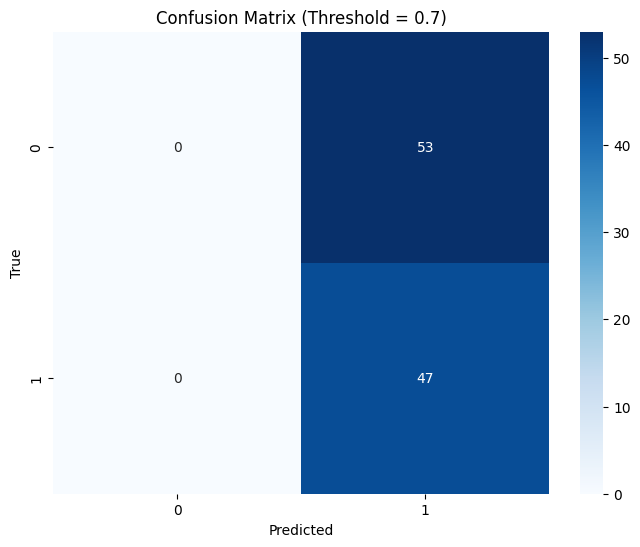

the accuracy is : 0.47 for dimension:: 10 at threshold ::  0.7


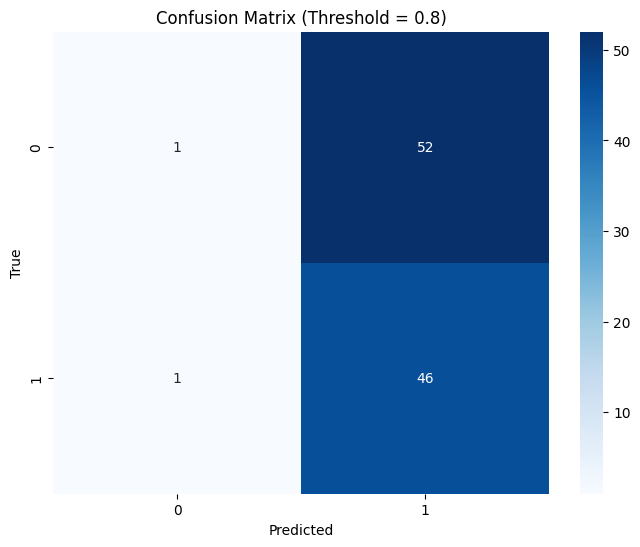

the accuracy is : 0.47 for dimension:: 10 at threshold ::  0.8


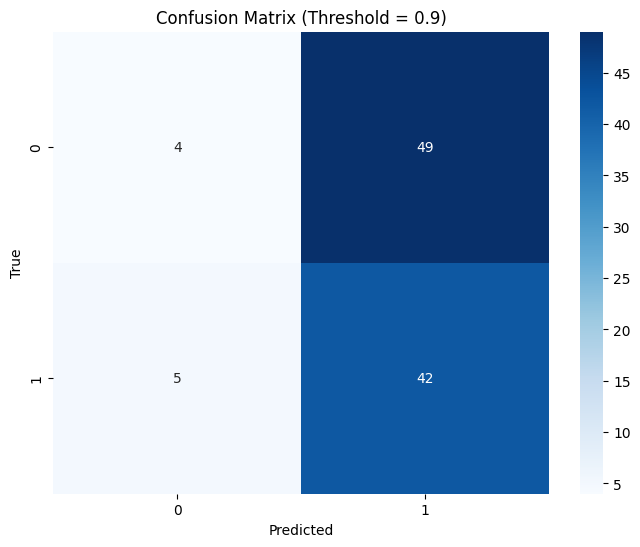

the accuracy is : 0.46 for dimension:: 10 at threshold ::  0.9
Epoch 1, Loss: 15235.6872
Epoch 2, Loss: 12807.7449
Epoch 3, Loss: 9683.2989
Epoch 4, Loss: 6325.3998
Epoch 5, Loss: 3912.3553
Epoch 6, Loss: 2538.1376
Epoch 7, Loss: 1731.0292
Epoch 8, Loss: 1248.6194
Epoch 9, Loss: 1006.0686
Epoch 10, Loss: 859.9505
Epoch 11, Loss: 786.0404
Epoch 12, Loss: 742.9491
Epoch 13, Loss: 707.6096
Epoch 14, Loss: 677.6056
Epoch 15, Loss: 651.1183
Epoch 16, Loss: 627.2058
Epoch 17, Loss: 605.0452
Epoch 18, Loss: 584.5089
Epoch 19, Loss: 565.2521
Epoch 20, Loss: 547.1942


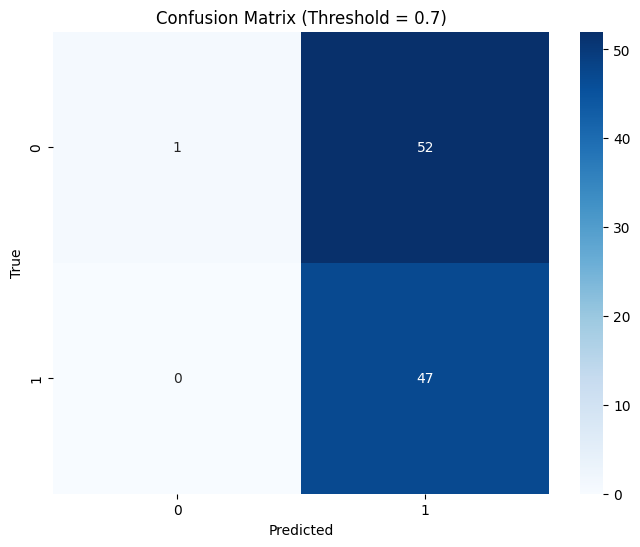

the accuracy is : 0.48 for dimension:: 20 at threshold ::  0.7


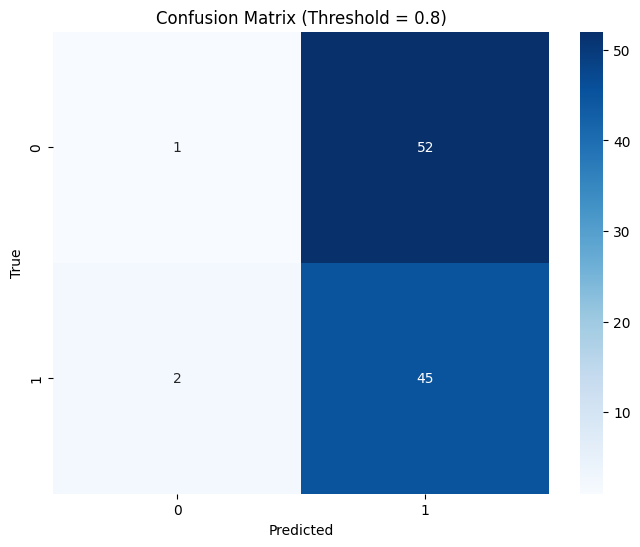

the accuracy is : 0.46 for dimension:: 20 at threshold ::  0.8


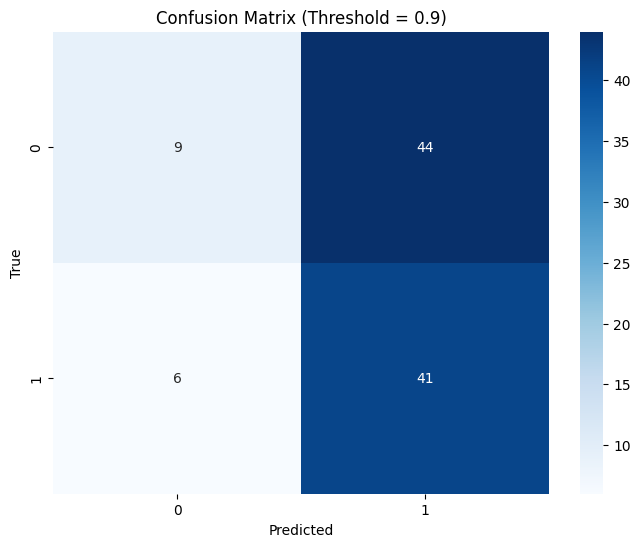

the accuracy is : 0.5 for dimension:: 20 at threshold ::  0.9
Epoch 1, Loss: 15236.1900
Epoch 2, Loss: 12498.2718
Epoch 3, Loss: 8705.7044
Epoch 4, Loss: 4801.2413
Epoch 5, Loss: 2507.8538
Epoch 6, Loss: 1475.0322
Epoch 7, Loss: 1037.0617
Epoch 8, Loss: 881.2026
Epoch 9, Loss: 797.5903
Epoch 10, Loss: 740.3415
Epoch 11, Loss: 697.1185
Epoch 12, Loss: 657.2305
Epoch 13, Loss: 626.6680
Epoch 14, Loss: 598.9376
Epoch 15, Loss: 574.2609
Epoch 16, Loss: 551.8257
Epoch 17, Loss: 531.0554
Epoch 18, Loss: 512.0612
Epoch 19, Loss: 494.3016
Epoch 20, Loss: 477.9974


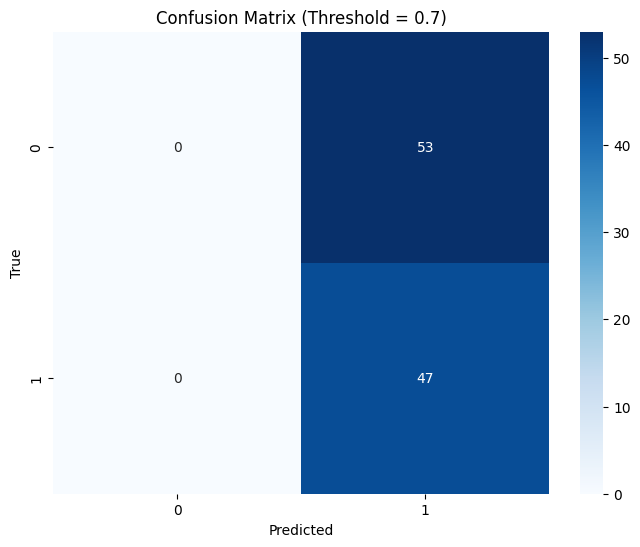

the accuracy is : 0.47 for dimension:: 30 at threshold ::  0.7


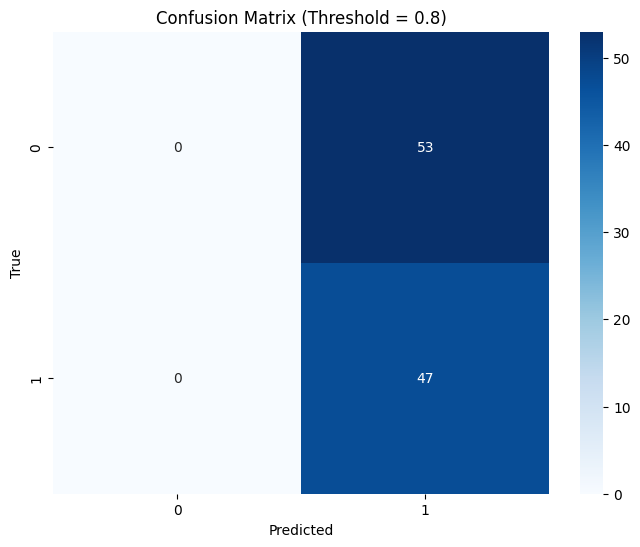

the accuracy is : 0.47 for dimension:: 30 at threshold ::  0.8


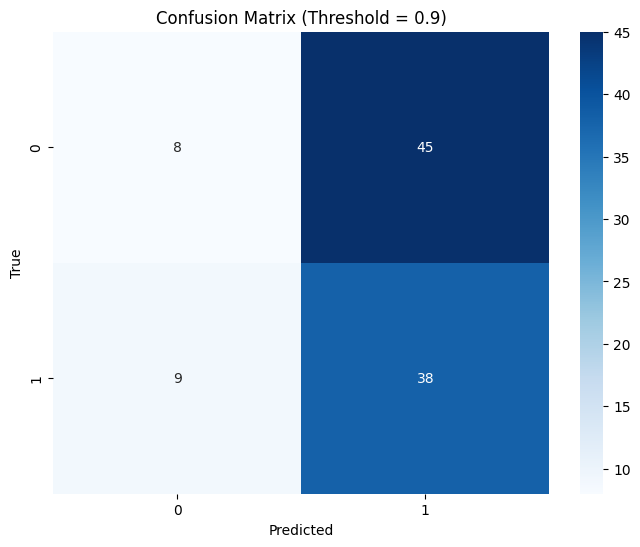

the accuracy is : 0.46 for dimension:: 30 at threshold ::  0.9
Epoch 1, Loss: 15142.4382
Epoch 2, Loss: 11983.1862
Epoch 3, Loss: 7579.6624
Epoch 4, Loss: 3663.0211
Epoch 5, Loss: 1856.8574
Epoch 6, Loss: 1160.0260
Epoch 7, Loss: 868.2192
Epoch 8, Loss: 767.2649
Epoch 9, Loss: 694.9985
Epoch 10, Loss: 659.6413
Epoch 11, Loss: 615.6251
Epoch 12, Loss: 581.5128
Epoch 13, Loss: 553.5514
Epoch 14, Loss: 528.7282
Epoch 15, Loss: 506.9059
Epoch 16, Loss: 486.7728
Epoch 17, Loss: 468.6543
Epoch 18, Loss: 452.6689
Epoch 19, Loss: 443.0148
Epoch 20, Loss: 435.1577


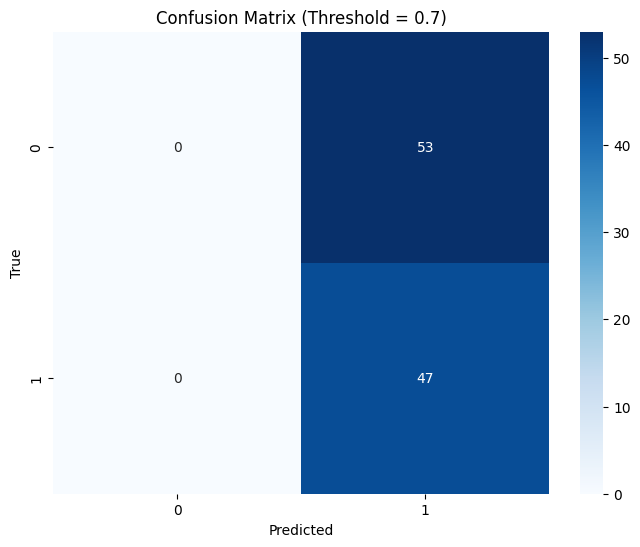

the accuracy is : 0.47 for dimension:: 40 at threshold ::  0.7


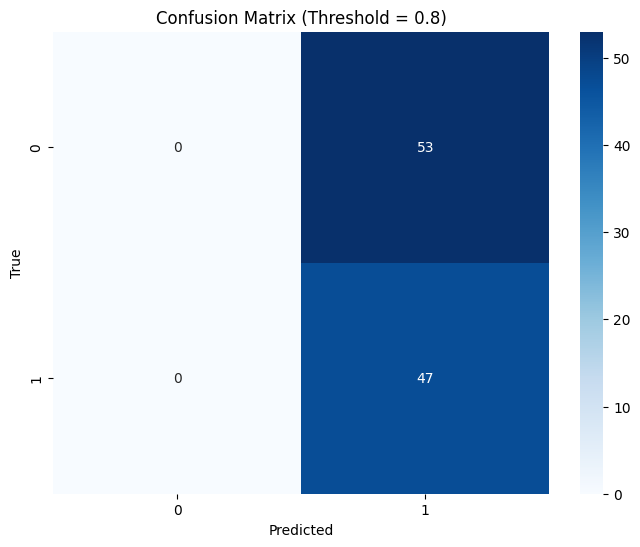

the accuracy is : 0.47 for dimension:: 40 at threshold ::  0.8


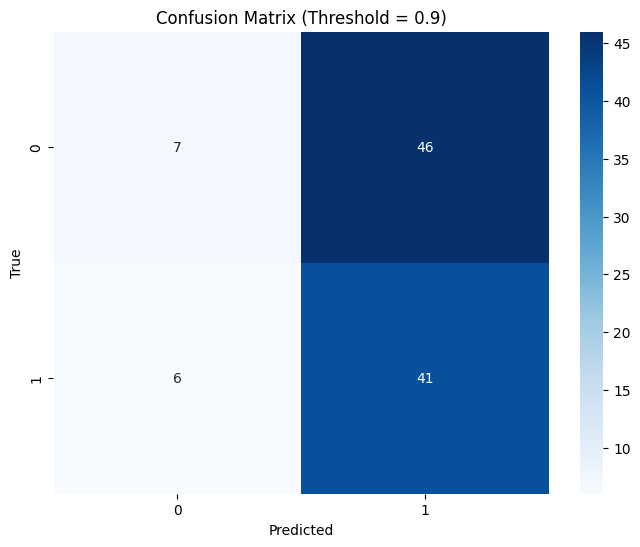

the accuracy is : 0.48 for dimension:: 40 at threshold ::  0.9
Epoch 1, Loss: 15107.1208
Epoch 2, Loss: 11685.0040
Epoch 3, Loss: 6978.4657
Epoch 4, Loss: 3121.4987
Epoch 5, Loss: 1536.6438
Epoch 6, Loss: 1020.9678
Epoch 7, Loss: 842.1182
Epoch 8, Loss: 754.8232
Epoch 9, Loss: 684.0465
Epoch 10, Loss: 631.1829
Epoch 11, Loss: 591.2359
Epoch 12, Loss: 558.7752
Epoch 13, Loss: 529.4380
Epoch 14, Loss: 504.8406
Epoch 15, Loss: 485.4856
Epoch 16, Loss: 465.2549
Epoch 17, Loss: 455.6841
Epoch 18, Loss: 441.0251
Epoch 19, Loss: 425.4714
Epoch 20, Loss: 420.1762


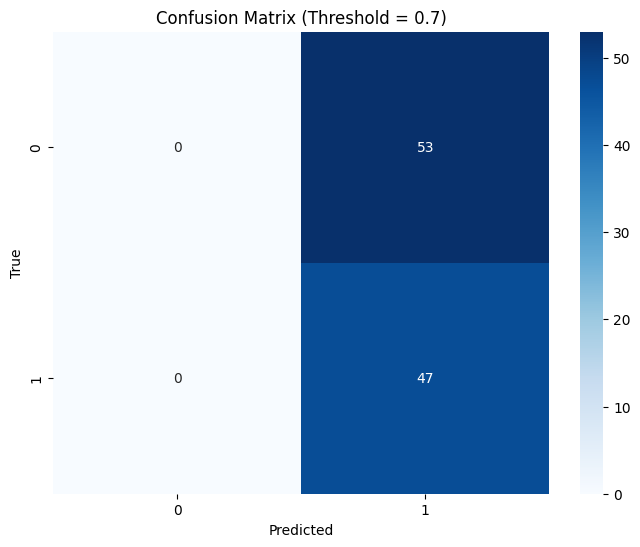

the accuracy is : 0.47 for dimension:: 50 at threshold ::  0.7


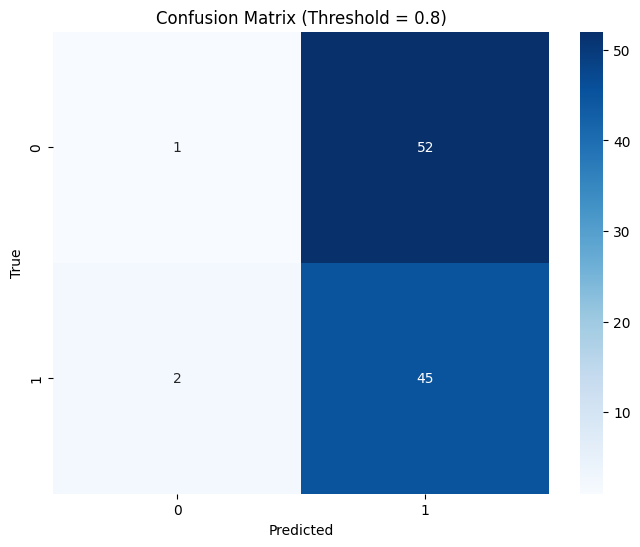

the accuracy is : 0.46 for dimension:: 50 at threshold ::  0.8


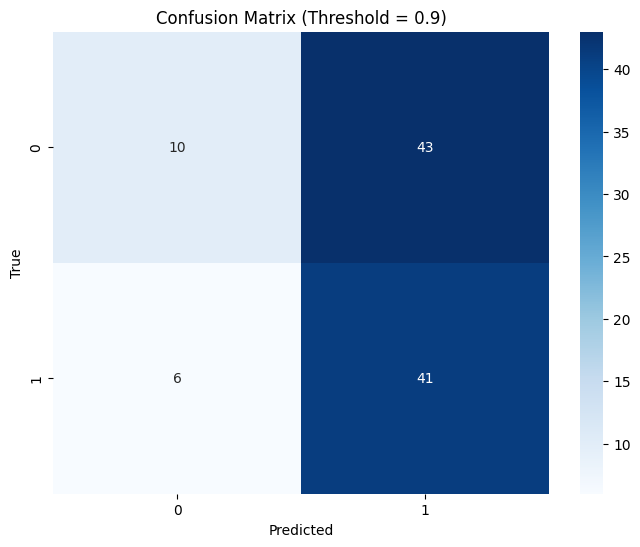

the accuracy is : 0.51 for dimension:: 50 at threshold ::  0.9


In [80]:
################################################################################
learning_curve_dict = {('dimension', 'threshold'): 'accuracy'} # in this part we train the model multiple times for different dimentions
for dimensions in range(10, 51, 10):

        # Loop 1
        model = CBOW(len(word_to_ix), dimensions)
        loss_function = nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        data = model.create_data_pairs(words, word_to_ix, 2)


        model.train_model(data, loss_function, optimizer, num_epochs=20)

        word_embeddings_dict = {}

        for word in vocab:
            embedding = model.get_word_emdedding(word)
            word_embeddings_dict[word] = embedding
         # Loop 2
        for threshold in [0.7, 0.8, 0.9]:   # also we test it on different thresholds beacause the label is 1 and 0 so there is not specific threshold to when it should be considered as a plagraizm
            x = pre_evaluation(df, threshold)
            acc = the_evaluation_matrices(x, threshold, dimensions, threshold) #in the evaluation we will get the accurac and the confusion matrix
            learning_curve_dict[(dimensions, threshold)] = acc

In [93]:
learning_curve_dict

{('dimension', 'threshold'): 'accuracy',
 (10, 0.7): 0.47,
 (10, 0.8): 0.47,
 (10, 0.9): 0.46,
 (20, 0.7): 0.48,
 (20, 0.8): 0.46,
 (20, 0.9): 0.5,
 (30, 0.7): 0.47,
 (30, 0.8): 0.47,
 (30, 0.9): 0.46,
 (40, 0.7): 0.47,
 (40, 0.8): 0.47,
 (40, 0.9): 0.48,
 (50, 0.7): 0.47,
 (50, 0.8): 0.46,
 (50, 0.9): 0.51}

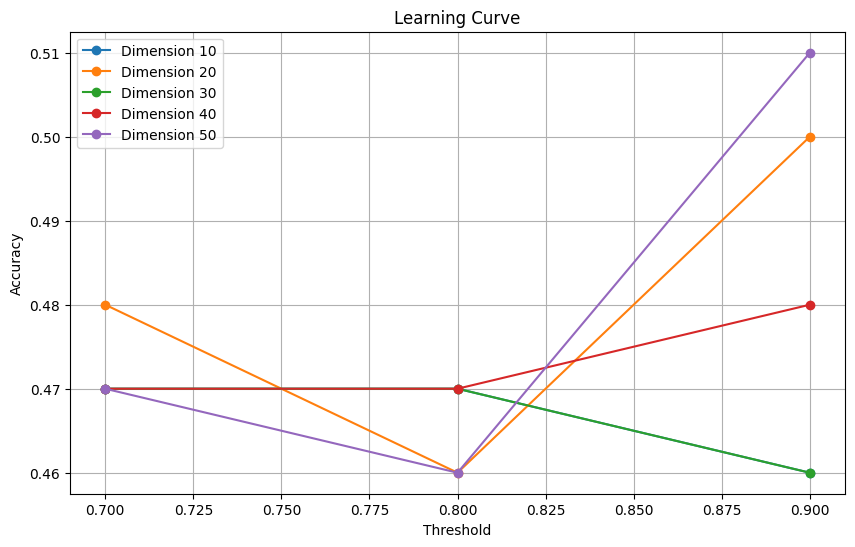

In [92]:

dimensions = []
thresholds = []
accuracies = []

for key, value in learning_curve_dict.items():
    if key != ('dimension', 'threshold'):
        dimension, threshold = key
        dimensions.append(dimension)
        thresholds.append(threshold)
        accuracies.append(value)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
for i, dimension in enumerate(np.unique(dimensions)):
    dimension_thresholds = [thresholds[j] for j in range(len(dimensions)) if dimensions[j] == dimension]
    dimension_accuracies = [accuracies[j] for j in range(len(dimensions)) if dimensions[j] == dimension]
    plt.plot(dimension_thresholds, dimension_accuracies, marker='o', label=f'Dimension {dimension}')

plt.title('Learning Curve')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()